Mounting your GoogleDrive

(GoogleDrive authorization will be asked)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis'

Mounted at /content/drive


NOTE: In the below Set-up section, adjust relevant file paths so that they will fit your directory structure.

---
# **Set-up**

In [2]:
RW_engine = 'pyogrio'
rasterSwitch = 'NO'

Importing module(s)

In [3]:
!pip install geopandas rioxarray richdem geemap rasterio import_ipynb pyshp pycrs pyogrio xarray-spatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 57.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.2 MB/s eta 0:00:00
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844528 sha256=0da9d546c05fe732fee89556c7b447035ee634756684f4729c5f3b883ca28d1a
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116b5cffecf04ed75c40f640e2baf231dae20954e31e0
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha25

In [6]:
# Colab default packages
import io
import os
import types
import sys
import glob
import importlib
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import pandas as pd
import json
import datetime
from sklearn.neighbors import KDTree
from shapely.geometry import mapping
from shapely import geometry
from shapely.validation import make_valid
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import metrics

# Temporarily installed packages
import geopandas as gpd
import xarray as xr
from xrspatial import zonal_stats
import rioxarray
import rasterio
from rasterio import features
import richdem as rd
import geemap
import pyogrio
import pycrs
import import_ipynb
from matplotlib.ticker import ScalarFormatter

# Import external files
os.chdir(program_location)
!pwd

sys.path.append(program_location)

import tools
importlib.reload(tools)


/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/tools.py'>

Generating an 'output' foldirectory in the target city directory

Adjust file path as you want.

In [7]:
data_loc = os.path.join(os.getcwd(), 'data')
output_loc = os.path.join(data_loc, 'output')
fig_loc = os.path.join(os.getcwd(), 'figs')


print(data_loc)
print(fig_loc)
print(output_loc)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/figs
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output


In [8]:
if not os.path.exists(output_loc):
    os.mkdir(output_loc)

---
# **Construct an Xarray dataset**

Convert all pre-downloaded VIIRS geotiff files to a single X-array dataset. This is a memory-heavy process. Need at least +50 GB RAM.

Here, you can select only OPTION-1 or OPTION-2. Both options cannot work at the same time. You need to reset the runtime if you want to work with another option.

## OPTION-1 VIIRS vesrsion (priority, monthly 2014-2023)

In [28]:
# Read the downloaded VIIRS rasters form local disk (check the data location specified by 'data_loc')
list_rasters = sorted( glob.glob(os.path.join(data_loc, 'output', 'viirs_monthly', '*.tif')) )

for x in list_rasters:
  print(x)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201401.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201402.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201403.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201404.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201405.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201406.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201407.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201408.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs_monthly/afg_viirs_201409.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analys

In [29]:
# Construct time coordinate
list_time = []

for y in range(2014, 2024):

    for m in range(1, 13):
      time_stamp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
      time_stamp = datetime.datetime.strptime(time_stamp, '%Y-%m-%d')

      list_time.append(time_stamp)


# Convert the time list to a time array
time = np.array(list_time)
time_var = xr.Variable('time', time)



# Construct VIIRS data array
da = xr.concat([rioxarray.open_rasterio(i) for i in list_rasters], dim = time_var)


# Convert the DA to a xarray dataset
ds = da.to_dataset("band")
ds = ds.rename({1: 'avg_rad'})

ds

<xarray.Dataset>
Dimensions:      (time: 120, y: 2188, x: 3460)
Coordinates:
  * x            (x) float64 60.48 60.48 60.49 60.49 ... 74.88 74.88 74.89 74.89
  * y            (y) float64 38.49 38.49 38.48 38.48 ... 29.39 29.39 29.38 29.38
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2023-12-01
Data variables:
    avg_rad      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      avg_rad

In [30]:
# Compute basic statistics
ds['sum'] = ds.avg_rad.sum(["x", "y"])
ds['sum_LOG'] = np.log(ds.avg_rad.sum(["x", "y"]))
ds['std'] = ds.avg_rad.std(dim = 'time')

## OPTION-2 VIIRS-like version (if you need extended time-series. 2000-2022, Only yearly)

In [16]:
# Read the downloaded VIIRS-like rasters form local disk (check the data location specified by 'data_loc')
# This is optional. Within this module, within a process, you can select either VIIRS or VIIRS-like to be processed.

list_rasters = sorted( glob.glob(os.path.join(data_loc, 'output', 'viirsLike_yearly', '*.tif')) )

for x in list_rasters:
  print(x)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2000.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2001.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2002.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2003.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2004.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2005.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2006.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2007.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2008.tif
/content/d

In [17]:
# Construct time coordinate
list_time = []

for y in range(2000, 2023):

        m = 1
        time_stamp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
        time_stamp = datetime.datetime.strptime(time_stamp, '%Y-%m-%d')

        list_time.append(time_stamp)


# Convert the time list to a time array
time = np.array(list_time)
time_var = xr.Variable('time', time)



# Construct VIIRS data array
da = xr.concat([rioxarray.open_rasterio(i) for i in list_rasters], dim = time_var)


# Convert the DA to a xarray dataset
ds = da.to_dataset("band")
ds = ds.rename({1: 'avg_rad'})

ds

<xarray.Dataset>
Dimensions:      (time: 23, y: 2188, x: 3460)
Coordinates:
  * x            (x) float64 60.48 60.48 60.49 60.49 ... 74.88 74.88 74.89 74.89
  * y            (y) float64 38.49 38.49 38.48 38.48 ... 29.39 29.39 29.38 29.38
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2022-01-01
Data variables:
    avg_rad      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  0.01343894118908271
    STATISTICS_MAXIMUM:      43.101516723633
    STATISTICS_MEAN:         0.0014013023804154
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.11592644732365
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               b1

In [18]:
# Compute basi statistics
ds['sum'] = ds.avg_rad.where(ds['avg_rad'] < 300).sum(["x", "y"])
ds['sum_LOG'] = np.log(ds.avg_rad.sum(["x", "y"]))
ds['std'] = ds.avg_rad.std(dim = 'time')

---
# **Filter-1: Noise reduction (background and max anomalies)**

**For the VIIRS-like data**, you must skip this section as it is already background noise reduced.

In [31]:
# Import annual mask created by Earth Observation Group, Payne Institute for Public Policy, Colorado School of Mines
src_ras = os.path.join(data_loc, 'output', 'ABCs', 'afg_viirs_ABC_2014_2021.tif')
mask_v21 = rioxarray.open_rasterio(src_ras)


# Here band is 'average_masked' that is extracted in the downloading process
ds_mask = mask_v21.to_dataset("band")
ds_mask = ds_mask.rename({1: 'mask'})

ds_mask['mask_bool'] = ds_mask['mask'] > 0


# Applying background noise and max anomaly filters to 'avg_rad' variable
# Here the max anomaly filter is set to avg_rad < 300

ds['avg_rad_BNR'] = ds['avg_rad'].where(ds_mask['mask_bool'] & (ds['avg_rad'] < 300) & (ds['avg_rad'] > 0))

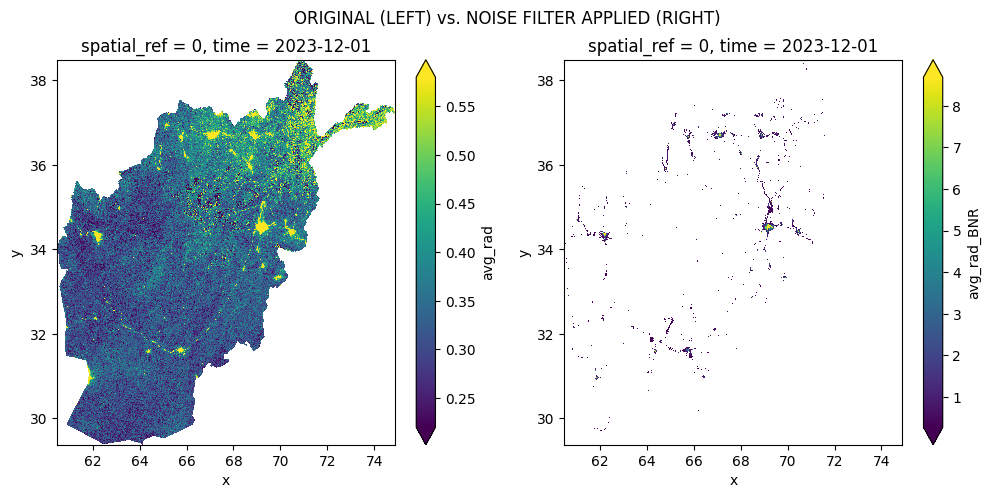

In [33]:
# Spatially visualize the filter effect (Right Panel)
sample_time = '2023-12-01'


fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = ds['avg_rad'].sel(time = sample_time).plot(robust = True)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = ds['avg_rad_BNR'].sel(time = sample_time).plot(robust = True)


# Add fig title
fig.suptitle("ORIGINAL (LEFT) vs. NOISE FILTER APPLIED (RIGHT)")

plt.show()

# Export fig (optional)
#src_fig_temp = os.path.join(fig_loc, 'spatial_visualization_of_BNR_effect.png')
#fig.savefig(src_fig_temp, bbox_inches="tight", dpi=500)

In [34]:
# Export the raster that the noise reduction filter applied if needed (OPTIONAL)

# Want export? 'yes' or 'no'
export_option = 'no'

if export_option == 'yes':

    for y in range(2014, 2024):

        for m in range(1, 13):
          time_temp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
          print(time_temp)

          # Construct a temporary file path
          out_ras_name = os.path.join(data_loc, 'output', 'NRA_afg_viirs_' + str(y) + str(m).zfill(2) + '01' + '.tif')


          # Export an x array
          ds['avg_rad_BNR'].sel(time = time_temp).rio.to_raster(out_ras_name)

---
# **Filter-2: OSM-Military filter**

### OSM-military polygon raster prep

First import the OSM military polygons

In [35]:
# Import
src_OSM_mBase = os.path.join(data_loc, 'OSM_military_base_ALL', 'OSM_military_base_ALL.shp')
gdf_OSM_mBase = tools.vec_import(RW_engine, src_OSM_mBase )

gdf_OSM_mBase['ID'] = gdf_OSM_mBase.index + 1


# Transform the CRS to that of DS
gdf_OSM_mBase.to_crs(ds.rio.crs, inplace = True)
gdf_OSM_mBase.crs

Vector import complete.
GDF size:558
EPSG:4326


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Rasterize the OSM polygons

In [36]:
# Rasterize the province geometry list
# You can select any template variable from DS, which must be 2 dimensional (x, y) without the time dimension.
# Here, we use the 'std' variable, which is a 2 dimensional variable.

r_base_ALL = features.rasterize(gdf_OSM_mBase['geometry'], out_shape = ds['std'].shape, transform = ds.rio.transform())

xr_baseALL = ds['std'].copy(deep = True)
xr_baseALL.data = r_base_ALL

# Convert to a DS and boolean array
ds_baseALL = xr_baseALL.to_dataset()
ds_baseALL['OSMmask_bool'] = ds_baseALL['std'] < 1
ds_baseALL = ds_baseALL.rename({'std': 'mask'})

ds_baseALL

<xarray.Dataset>
Dimensions:       (x: 3460, y: 2188)
Coordinates:
  * x             (x) float64 60.48 60.48 60.49 60.49 ... 74.88 74.89 74.89
  * y             (y) float64 38.49 38.49 38.48 38.48 ... 29.39 29.38 29.38
    spatial_ref   int64 0
Data variables:
    mask          (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    OSMmask_bool  (y, x) bool True True True True True ... True True True True

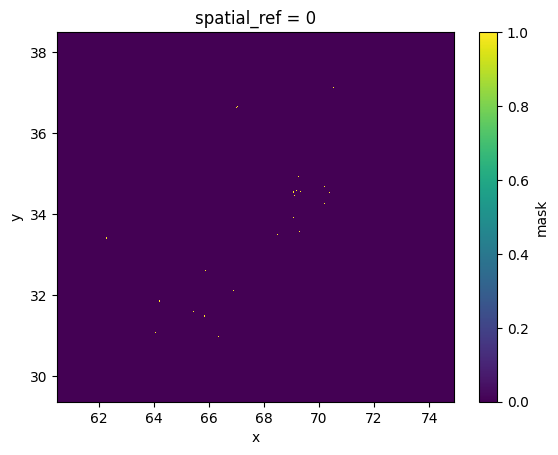

In [37]:
# eye check
ds_baseALL['mask'].plot()

NON-BNR DATA: Check Zonal statistics in each military mask

In [38]:
zonal_stats(ds_baseALL['mask'], ds['std'])

,zone,mean,max,min,sum,std,var,count
0,0,0.138722,77.111273,0.000,501108.152154,0.194358,0.037775,3612323.0
1,1,7.035686,66.965137,0.085,8421.715869,11.294819,127.572940,1197.0


### Apply the OSM-military polygon filter

For the VIIRS-like data, you must skip this sub-section as it is already OSM-military filtered.

In [39]:
# Apply the OSM filter to avg_rad BNR
ds['avg_rad_BNR_OSM'] = ds['avg_rad_BNR'].where(ds_baseALL['OSMmask_bool'])

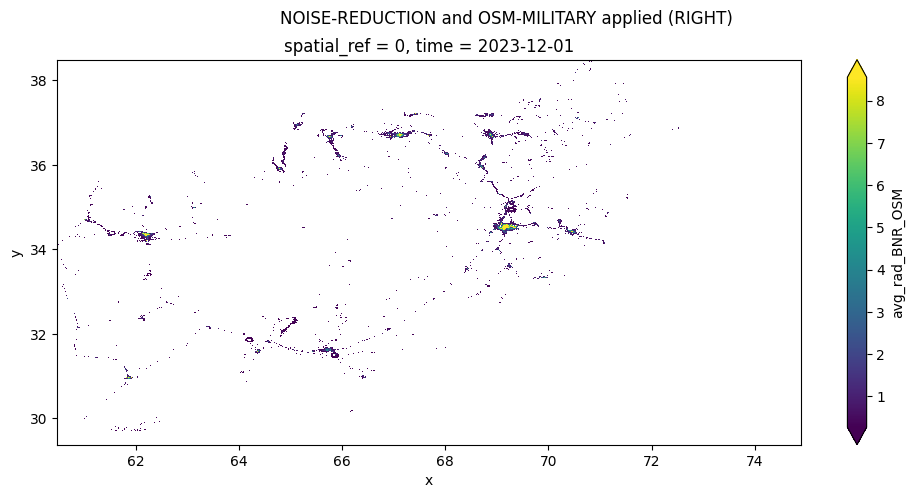

In [40]:
# eye check

fig = plt.figure(figsize = (12, 5))

ax2 = fig.add_subplot(1, 1, 1)
ax2 = ds['avg_rad_BNR_OSM'].sel(time = sample_time).plot(robust = True)


# Add fig title
fig.suptitle("NOISE-REDUCTION and OSM-MILITARY applied (RIGHT)")

plt.show()

# Export fig
#src_fig_temp = os.path.join(fig_loc, 'spatial_visualization_of_OSM_filter_effect.png')
#fig.savefig(src_fig_temp, bbox_inches="tight", dpi=500)

In [41]:
# Export the raster that the noise-reduced, OSM-military filiter applied if needed (OPTIONAL)

# Want export? 'yes' or 'no'
export_option = 'no'

if export_option == 'yes':

    for y in range(2014, 2024):

        for m in range(1, 13):
          time_temp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
          print(time_temp)

          # Construct a temporary file path
          out_ras_name = os.path.join(data_loc, 'output', 'NRAOSM_afg_viirs_' + str(y) + str(m).zfill(2) + '01' + '.tif')


          # Export an x array
          ds['avg_rad_BNR_OSM'].sel(time = time_temp).rio.to_raster(out_ras_name)

---
# **Apply simple OSM-SDV mask at provincial level (Product 1)**

### Provincial raster prep

Import an admin border shapefile of interest and rasterize it using a unique ID. The target shapefile must hava one unique ID column.

In [42]:
# Import adm1 vector
src_adm1 = os.path.join(data_loc, 'adm1_2024', 'adm1_2024.shp')
gdf_adm1 = tools.vec_import(RW_engine, src_adm1)

# Transform the CRS to that of DS
gdf_adm1.to_crs(ds.rio.crs, inplace = True)
gdf_adm1.crs

# Check inside
gdf_adm1

Vector import complete.
GDF size:34
EPSG:4326


,Prov_name,Area_SQkm,Area_SQm,ProvCode_1,ProvCode_0,UNProvCode,CSO_Name,CSO_Region,ALCSName,geometry
0,Badakhshan,43460.082507,4.346008e+10,17,14,15,Badakhshan,Northeast,Badakhshan,"POLYGON Z ((71.00473 38.47497 0.00000, 71.0056..."
1,Badghes,20709.235868,2.070924e+10,31,23,29,Badghis,West,Badghis,"POLYGON Z ((63.92890 35.88632 0.00000, 63.9290..."
2,Baghlan,17803.307648,1.780331e+10,9,16,9,Baghlan,Northeast,Baghlan,"MULTIPOLYGON Z (((69.26802 35.39363 0.00000, 6..."
3,Balkh,16769.211164,1.676921e+10,21,19,18,Balkh,North,Balkh,"POLYGON Z ((67.01089 37.37373 0.00000, 67.0118..."
4,Bamyan,17878.329500,1.787833e+10,10,32,10,Bamyan,WestCentral,Bamyan,"POLYGON Z ((67.81901 35.47557 0.00000, 67.8201..."
5,Daykundi,16683.967227,1.668397e+10,24,34,22,Daykundi,WestCentral,Daykundi,"MULTIPOLYGON Z (((66.88292 33.28452 0.00000, 6..."
6,Farah,49590.770919,4.959077e+10,33,25,31,Farah,West,Farah,"POLYGON Z ((63.37812 33.63556 0.00000, 63.3783..."
7,Faryab,20718.484117,2.071848e+10,29,22,28,Faryab,North,Faryab,"POLYGON Z ((65.24546 37.24355 0.00000, 65.2680..."
8,Ghazni,21750.681401,2.175068e+10,11,6,11,Ghazni,South,Ghazni,"POLYGON Z ((68.07217 34.19480 0.00000, 68.0751..."
9,Ghor,37112.590275,3.711259e+10,23,31,21,Ghor,WestCentral,Ghor,"POLYGON Z ((65.64539 35.26233 0.00000, 65.6453..."


In [43]:
# Specify a unique code for the further processes and check it is really unique

print('No. of admin = {}'.format(len(gdf_adm1)))
print('No. of unique codes = {}'.format(len(gdf_adm1['UNProvCode'].unique())))

l_ucode_check = sorted(gdf_adm1['UNProvCode'].unique())

print(l_ucode_check)

No. of admin = 34
No. of unique codes = 34
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [44]:
# Convert to a province geometry list
geom = gdf_adm1[['geometry', 'UNProvCode']].values.tolist()

In [45]:
# Rasterize the province geometry list
# You can select any template variable from DS, which must be 2 dimensional (x, y) without the time dimension.
# Here, we use the 'std' variable, which is a 2 dimensional variable.

r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

xr_temp = ds['std'].copy(deep = True)
xr_temp.data = r_temp

ds_temp = xr_temp.to_dataset()
ds_temp = ds_temp.rename({'std': 'province_id'})

ds_temp

<xarray.Dataset>
Dimensions:      (x: 3460, y: 2188)
Coordinates:
  * x            (x) float64 60.48 60.48 60.49 60.49 ... 74.88 74.88 74.89 74.89
  * y            (y) float64 38.49 38.49 38.48 38.48 ... 29.39 29.39 29.38 29.38
    spatial_ref  int64 0
Data variables:
    province_id  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

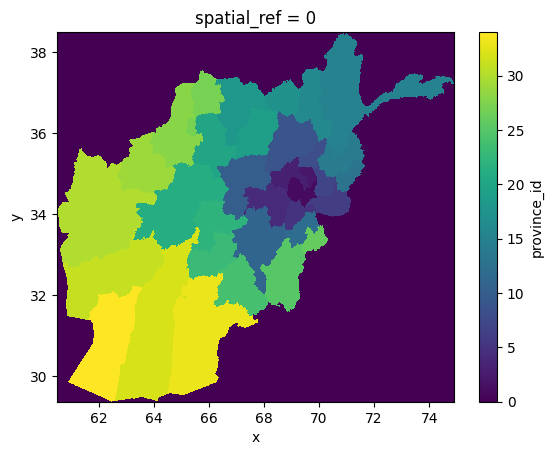

In [46]:
# Visualize the province raster to eye check
ds_temp['province_id'].plot(robust = True)

### Monthly-provincial level zonal statistics (VIIRS option)

In [47]:
# Montly
l_year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
l_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)


for y in l_year:

  for m in l_month:

      time_tar = y + '-' + m + '-01'
      time_stamp = y + '-' + m

      print(time_tar)

      # Summary Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

      df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)

      # Within OSM Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) ))


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


      # Within OSM+SDV Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100

2014-01-01
2014-02-01
2014-03-01
2014-04-01
2014-05-01
2014-06-01
2014-07-01
2014-08-01
2014-09-01
2014-10-01
2014-11-01
2014-12-01
2015-01-01
2015-02-01
2015-03-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01
2015-11-01
2015-12-01
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01
2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01
2020-01-01
2020-02-01
2020-03-01
2020-04-01
2020-05-01
2020-06-01
2020-07-01
2020-08-01
2020-09-01
2020-10-01
2020-11-01
2020-12-01
2021-01-01
2021-02-01
2021-03-01
2021-04-01
2021-05-01
2021-06-01
2021-07-01

In [48]:
# Rename the 'ID' colmun to the original unique ID name and review inside:
df_out = df_out.rename(columns = {'ID': 'UNProvCode'})
df_out

,province,UNProvCode,2014-01_mean,2014-01_max,2014-01_min,2014-01_sum,2014-01_std,2014-01_var,2014-01_sum(OSM),2014-01_OSM%,...,2023-12_mean,2023-12_max,2023-12_min,2023-12_sum,2023-12_std,2023-12_var,2023-12_sum(OSM),2023-12_OSM%,2023-12_sum(OSM+SDV),2023-12_OSM+SDV%
0,Badakhshan,15,0.337859,2.750694,0.070172,718.963548,0.204811,0.041948,6.657494,0.925985,...,0.603732,8.300000,0.06,1276.289997,0.426683,0.182059,4.760000,0.372956,4.760000,0.372956
1,Badghes,29,0.351325,7.171637,0.078980,187.256272,0.651119,0.423957,10.041926,5.362665,...,0.710338,7.630000,0.22,378.610000,0.897880,0.806189,1.840000,0.485988,1.840000,0.485988
2,Baghlan,9,0.459435,9.951041,0.089976,1586.888274,0.721020,0.519870,9.347147,0.589024,...,0.900589,10.330000,0.15,3089.019996,0.931814,0.868278,5.310000,0.171899,5.310000,0.171899
3,Balkh,18,1.632640,118.745522,0.038397,9885.637233,5.033956,25.340712,1668.500433,16.878026,...,1.642076,33.080002,0.24,9942.769999,2.530240,6.402116,165.299999,1.662515,203.509999,2.046814
4,Bamyan,10,0.298018,2.949066,0.110233,169.870232,0.275740,0.076032,0.276078,0.162523,...,0.639386,4.390000,0.23,364.449999,0.542326,0.294117,0.480000,0.131705,0.480000,0.131705
5,Daykundi,22,0.203888,0.636096,0.092715,40.777533,0.093555,0.008753,NaN,NaN,...,0.477500,2.400000,0.20,95.500000,0.319645,0.102173,NaN,NaN,NaN,NaN
6,Farah,31,0.199210,3.837252,0.035594,307.778739,0.288440,0.083198,24.970074,8.112995,...,0.617592,17.910000,0.19,954.179999,1.050788,1.104156,12.540000,1.314217,12.540000,1.314217
7,Faryab,28,0.354301,6.787757,0.047410,1446.612661,0.516753,0.267034,0.687940,0.047555,...,0.761519,22.230000,0.11,3093.289994,1.072217,1.149648,0.280000,0.009052,0.280000,0.009052
8,Ghazni,11,0.237397,1.765336,0.075707,249.029660,0.159117,0.025318,9.140370,3.670394,...,0.689209,15.100000,0.24,722.979999,0.982655,0.965611,18.080000,2.500761,33.180000,4.589339
9,Ghor,21,0.339067,2.718901,0.084882,38.992755,0.391462,0.153242,0.472456,1.211650,...,0.469912,1.610000,0.22,53.570000,0.271734,0.073839,1.030000,1.922718,1.030000,1.922718


In [ ]:
# Export the zonal-stats table

src_out = os.path.join(data_loc, 'monthly_summary_stats_adm1_2024_v2.csv')
df_out.to_csv(src_out, index = False)

### Yearly-provincial level zonal statistics (VIIRS-like option)

In [ ]:
df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)


for y in range(2000, 2023):


      time_tar = str(y) + '-01-01'
      time_stamp = str(y)


      print(time_tar)

      # Summary Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad'].sel(time = time_tar))

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

      df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)

      # Within OSM Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) ))


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


      # Within OSM+SDV Stats
      df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100

2000-01-01
2001-01-01
2002-01-01
2003-01-01
2004-01-01
2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01


In [ ]:
# Rename the 'ID' colmun to the original unique ID name and review inside:
df_out = df_out.rename(columns = {'ID': 'UNProvCode'})
df_out

,province,UNProvCode,2000_mean,2000_max,2000_min,2000_sum,2000_std,2000_var,2000_sum(OSM),2000_OSM%,...,2022_mean,2022_max,2022_min,2022_sum,2022_std,2022_var,2022_sum(OSM),2022_OSM%,2022_sum(OSM+SDV),2022_OSM+SDV%
0,Badakhshan,15,0.000005,1.227584,0.0,1.227584,0.002440,0.000006,0.000000,0.000000,...,0.000477,5.175000,0.0,120.399999,0.031543,0.000995,0.000000,0.000000,0.000000,0.000000
1,Badghes,29,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000813,5.200000,0.0,89.310000,0.043287,0.001874,0.000000,0.000000,0.000000,0.000000
2,Baghlan,9,0.000784,3.349958,0.0,76.846228,0.041764,0.001744,0.000000,0.000000,...,0.011749,8.735001,0.0,1151.585002,0.186745,0.034874,0.000000,0.000000,0.000000,0.000000
3,Balkh,18,0.002008,5.054233,0.0,203.936320,0.071908,0.005171,0.000000,0.000000,...,0.055600,22.994999,0.0,5614.344996,0.541850,0.293602,152.545000,2.717058,544.349996,9.695699
4,Bamyan,10,0.000077,2.869491,0.0,7.854337,0.012892,0.000166,0.000000,0.000000,...,0.000564,5.315000,0.0,57.675000,0.037972,0.001442,0.000000,0.000000,0.000000,0.000000
5,Daykundi,22,0.000040,1.065510,0.0,3.068321,0.006416,0.000041,NaN,NaN,...,0.000095,1.340000,0.0,7.275000,0.010804,0.000117,NaN,NaN,NaN,NaN
6,Farah,31,0.000005,1.089565,0.0,1.089565,0.002292,0.000005,0.000000,0.000000,...,0.000681,10.670000,0.0,153.724999,0.053866,0.002902,0.000000,0.000000,0.000000,0.000000
7,Faryab,28,0.000976,6.580259,0.0,117.029610,0.063693,0.004057,0.000000,0.000000,...,0.011293,11.809999,0.0,1354.029997,0.187096,0.035005,0.000000,0.000000,0.000000,0.000000
8,Ghazni,11,0.000232,2.582998,0.0,27.884848,0.020716,0.000429,0.000000,0.000000,...,0.001810,11.860001,0.0,217.065001,0.082520,0.006810,0.000000,0.000000,0.000000,0.000000
9,Ghor,21,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN


In [ ]:
# Export the zonal-stats table

src_out = os.path.join(data_loc, 'VIIRS-like_yearly_summary_stats_adm1_2024_v1.csv')
df_out.to_csv(src_out, index = False)

---
## **Apply Walker-verified SDV-based mask at provincial level (Product 2)**

Only available for the VIIRS option.

#### Import the Walker-verified SDV-based mask polygons and rasterize it.

In [49]:
# Import the SDV mask shape
src_aoi = os.path.join(data_loc, 'sdv_mask_verified', 'sdv_mask.shp')
gdf_aoi = tools.vec_import(RW_engine, src_aoi )


# Transform the CRS to that of DS
gdf_aoi.to_crs(ds.rio.crs, inplace = True)
gdf_aoi.crs


# Generate zone ID
gdf_SDV_tar = gdf_aoi.query('priority == 1')
gdf_SDV_tar['zoneID'] = gdf_SDV_tar.index

gdf_SDV_tar.head(5)

Vector import complete.
GDF size:265
EPSG:4326


,maskCode,Base,Checked,Erroneous,Discuss,priority,geometry,zoneID
16,SDV1,1,1,0,0,1,"POLYGON ((69.30399 34.58741, 69.30815 34.58741...",16
17,SDV1,1,1,0,0,1,"POLYGON ((69.29565 34.57074, 69.28732 34.57074...",17
18,SDV1,1,1,0,0,1,"POLYGON ((69.19982 34.56241, 69.19149 34.56241...",18
19,SDV1,1,1,0,0,1,"POLYGON ((69.32899 34.55408, 69.32482 34.55408...",19
20,SDV1,1,1,0,0,1,"POLYGON ((69.23732 34.54574, 69.23315 34.54574...",20


Import the definition matrix of the opening and closing of bases.

In [52]:
# Import mask definition CSV
df_maskDef = pd.read_csv(os.path.join(data_loc, 'complete_sdv_mask_20240430.csv'))


# Convert the SDV mask values to mask classes
def mask_val_convert(x):

  if x < 0.25:
    x = 0

  elif x < 0.5 :
    x = 2

  else:
    x = 1

  return x


for y in range(2014, 2024):

  tar_col = 'Y' + str(y)
  print(tar_col)
  df_maskDef[tar_col] = df_maskDef[tar_col].apply(lambda x: mask_val_convert(x))


# Check the DF
df_maskDef.head(5)

Y2014
Y2015
Y2016
Y2017
Y2018
Y2019
Y2020
Y2021
Y2022
Y2023


,zoneID,zoneName,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023
0,16,Within Kabul,0,0,1,1,1,1,1,1,0,0
1,17,Within Kabul,2,2,1,1,1,1,1,1,0,0
2,18,Within Kabul,1,1,1,1,1,1,1,2,0,0
3,19,Within Kabul,1,1,1,1,1,1,1,2,0,0
4,20,Within Kabul,1,1,1,1,1,1,1,1,0,0


In [53]:
# Merge shape and mask definition

df_maskDef_temp = df_maskDef.copy()
gdf_SDV_tar_temp = gdf_SDV_tar[['zoneID', 'geometry']].copy()

gdf_SDV_mask = gdf_SDV_tar_temp.merge(df_maskDef_temp, on = 'zoneID', how = 'inner')

gdf_SDV_mask.head(5)

,zoneID,geometry,zoneName,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023
0,16,"POLYGON ((69.30399 34.58741, 69.30815 34.58741...",Within Kabul,0,0,1,1,1,1,1,1,0,0
1,17,"POLYGON ((69.29565 34.57074, 69.28732 34.57074...",Within Kabul,2,2,1,1,1,1,1,1,0,0
2,18,"POLYGON ((69.19982 34.56241, 69.19149 34.56241...",Within Kabul,1,1,1,1,1,1,1,2,0,0
3,19,"POLYGON ((69.32899 34.55408, 69.32482 34.55408...",Within Kabul,1,1,1,1,1,1,1,2,0,0
4,20,"POLYGON ((69.23732 34.54574, 69.23315 34.54574...",Within Kabul,1,1,1,1,1,1,1,1,0,0


#### Apply the Walker-verified mask and compute the monthly-provincial level zonal statisitcs

##### Version 1 - not apply the Walker-verified mask after 2021 Oct.

In [ ]:
# Montly
l_year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
#l_year = ['2020']
l_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)


for y in l_year:


    # Prep a temporary SDV mask raster (by year)
    year_col = 'Y' + str(y)

    geom = gdf_SDV_mask[['geometry', year_col]].values.tolist()

    r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

    xr_temp = ds['std'].copy(deep = True)
    xr_temp.data = r_temp

    ds_SDVmask = xr_temp.to_dataset()
    ds_SDVmask = ds_SDVmask.rename({'std': 'SDVmask'})

    # Convert to a DS and boolean array
    ds_SDVmask['SDVmask_bool'] = ds_SDVmask['SDVmask'] > 0



    # Check year


    if int(y) < 2021:

        for m in l_month:

            time_tar = y + '-' + m + '-01'
            time_stamp = y + '-' + m

            print(time_tar)


            # Summary Stats
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

            #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
            df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
            df_out.drop(columns = ['zone'], inplace = True)



            # [A] Within SDV-mask Stats (Potentially Coalition bases)
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


            df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

            df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
            df_out.drop(columns = ['zone'], inplace = True)


            df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



            # [B] Within SDV-mask Stats (Potentially Afghan bases)
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


            df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

            df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
            df_out.drop(columns = ['zone'], inplace = True)


            df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100




    elif int(y) == 2021:#Special loop for year 2021

        for m in l_month:

            if int(m) < 10:

                time_tar = y + '-' + m + '-01'
                time_stamp = y + '-' + m

                print(time_tar)


                # Summary Stats
                df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

                df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

                #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
                df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
                df_out.drop(columns = ['zone'], inplace = True)



                # [A] Within SDV-mask Stats (Potentially Coalition bases)
                df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


                df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

                df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

                df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
                df_out.drop(columns = ['zone'], inplace = True)


                df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



                # [B] Within SDV-mask Stats (Potentially Afghan bases)
                df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


                df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

                df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

                df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
                df_out.drop(columns = ['zone'], inplace = True)


                df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


            else:

                time_tar = y + '-' + m + '-01'
                time_stamp = y + '-' + m

                print(time_tar)


                # Summary Stats
                df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

                df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

                #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
                df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
                df_out.drop(columns = ['zone'], inplace = True)



                # [A] Within SDV-mask Stats (Potentially Coalition bases) MASK OFF
                df_out[time_stamp + '_sum(Coalition)'] = ''
                df_out[time_stamp + '_Coalition%'] = ''



                # [B] Within SDV-mask Stats (Potentially Afghan bases) MASK OFF
                df_out[time_stamp + '_sum(Afghan)'] = ''
                df_out[time_stamp + '_Afghan%'] = ''



    else:#Special loop for year 2022-2023

        for m in l_month:

            time_tar = y + '-' + m + '-01'
            time_stamp = y + '-' + m

            print(time_tar)


            # Summary Stats
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

            #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
            df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
            df_out.drop(columns = ['zone'], inplace = True)



            # [A] Within SDV-mask Stats (Potentially Coalition bases) MASK OFF
            df_out[time_stamp + '_sum(Coalition)'] = ''
            df_out[time_stamp + '_Coalition%'] = ''



            # [B] Within SDV-mask Stats (Potentially Afghan bases) MASK OFF
            df_out[time_stamp + '_sum(Afghan)'] = ''
            df_out[time_stamp + '_Afghan%'] = ''

2014-01-01
2014-02-01
2014-03-01
2014-04-01
2014-05-01
2014-06-01
2014-07-01
2014-08-01
2014-09-01
2014-10-01
2014-11-01
2014-12-01
2015-01-01
2015-02-01
2015-03-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01
2015-11-01
2015-12-01
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01
2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01
2020-01-01
2020-02-01
2020-03-01
2020-04-01
2020-05-01
2020-06-01
2020-07-01
2020-08-01
2020-09-01
2020-10-01
2020-11-01
2020-12-01
2021-01-01
2021-02-01
2021-03-01
2021-04-01
2021-05-01
2021-06-01
2021-07-01

##### Version 2 - apply the Walker-verified mask even after 2021 Oct.

In [ ]:
# Montly
l_year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
#l_year = ['2020']
l_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)


for y in l_year:


    # Prep a temporary SDV mask raster (by year)
    year_col = 'Y' + str(y)

    geom = gdf_SDV_mask[['geometry', year_col]].values.tolist()

    r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

    xr_temp = ds['std'].copy(deep = True)
    xr_temp.data = r_temp

    ds_SDVmask = xr_temp.to_dataset()
    ds_SDVmask = ds_SDVmask.rename({'std': 'SDVmask'})

    # Convert to a DS and boolean array
    ds_SDVmask['SDVmask_bool'] = ds_SDVmask['SDVmask'] > 0



    # Check year


    if int(y) < 2024:

        for m in l_month:

            time_tar = y + '-' + m + '-01'
            time_stamp = y + '-' + m

            print(time_tar)


            # Summary Stats
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

            #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
            df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
            df_out.drop(columns = ['zone'], inplace = True)



            # [A] Within SDV-mask Stats (Potentially Coalition bases)
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


            df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

            df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
            df_out.drop(columns = ['zone'], inplace = True)


            df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



            # [B] Within SDV-mask Stats (Potentially Afghan bases)
            df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


            df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

            df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

            df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
            df_out.drop(columns = ['zone'], inplace = True)


            df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2014-01-01
2014-02-01
2014-03-01
2014-04-01
2014-05-01
2014-06-01
2014-07-01
2014-08-01
2014-09-01
2014-10-01
2014-11-01
2014-12-01
2015-01-01
2015-02-01
2015-03-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2015-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2015-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2015-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2016-01-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

2016-02-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-03-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-05-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-06-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-07-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-08-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-10-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2016-12-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-01-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-03-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-04-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-05-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-06-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-07-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-08-01
2017-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2017-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2017-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2017-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-01-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-03-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-05-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-06-01
2018-07-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2018-08-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2018-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2018-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-01-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2019-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2019-03-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2019-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-05-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-06-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-07-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-08-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2019-10-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

2019-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2019-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2020-01-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2020-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2020-03-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2020-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-05-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-06-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-07-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-08-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-09-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-10-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2020-12-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2021-01-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-03-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2021-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-05-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-06-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-07-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-08-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2021-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2021-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2021-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2021-12-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-01-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2022-03-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2022-04-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2022-05-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-06-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-07-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-08-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2022-09-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2022-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2022-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2023-01-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-02-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-03-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-04-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100
<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-05-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-06-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-07-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-08-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-09-01


<ipython-input-25-d33068e92c07>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


2023-10-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2023-11-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


2023-12-01


<ipython-input-25-d33068e92c07>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100


##### Post process and export the product CSV

In [ ]:
# Rename the 'ID' colmun to the original unique ID name and review inside:
df_out = df_out.rename(columns = {'ID': 'UNProvCode'})
df_out

,province,UNProvCode,2014-01_sum,2014-01_sum(Coalition),2014-01_Coalition%,2014-01_sum(Afghan),2014-01_Afghan%,2014-02_sum,2014-02_sum(Coalition),2014-02_Coalition%,...,2023-11_sum,2023-11_sum(Coalition),2023-11_Coalition%,2023-11_sum(Afghan),2023-11_Afghan%,2023-12_sum,2023-12_sum(Coalition),2023-12_Coalition%,2023-12_sum(Afghan),2023-12_Afghan%
0,Badakhshan,15,718.963548,NaN,NaN,NaN,NaN,735.878927,NaN,NaN,...,1448.429996,NaN,NaN,NaN,NaN,1276.289997,NaN,NaN,NaN,NaN
1,Badghes,29,187.256272,13.223180,7.061542,NaN,NaN,281.220425,21.574530,7.671751,...,496.589998,NaN,NaN,NaN,NaN,378.610000,NaN,NaN,NaN,NaN
2,Baghlan,9,1586.888274,NaN,NaN,NaN,NaN,1767.429291,NaN,NaN,...,3747.419998,NaN,NaN,NaN,NaN,3089.019996,NaN,NaN,NaN,NaN
3,Balkh,18,9885.637233,2646.399646,26.770147,NaN,NaN,11879.320194,2571.259595,21.644838,...,10879.429995,23.629999,0.217199,NaN,NaN,9942.769999,26.349999,0.265017,NaN,NaN
4,Bamyan,10,169.870232,NaN,NaN,NaN,NaN,187.755142,NaN,NaN,...,434.279999,NaN,NaN,NaN,NaN,364.449999,NaN,NaN,NaN,NaN
5,Daykundi,22,40.777533,NaN,NaN,NaN,NaN,61.511926,NaN,NaN,...,115.419999,NaN,NaN,NaN,NaN,95.500000,NaN,NaN,NaN,NaN
6,Farah,31,307.778739,NaN,NaN,NaN,NaN,395.869281,NaN,NaN,...,1202.839997,NaN,NaN,NaN,NaN,954.179999,NaN,NaN,NaN,NaN
7,Faryab,28,1446.612661,NaN,NaN,NaN,NaN,1746.655456,NaN,NaN,...,4154.660001,NaN,NaN,NaN,NaN,3093.289994,NaN,NaN,NaN,NaN
8,Ghazni,11,249.029660,NaN,NaN,NaN,NaN,347.467809,NaN,NaN,...,942.939998,NaN,NaN,NaN,NaN,722.979999,NaN,NaN,NaN,NaN
9,Ghor,21,38.992755,NaN,NaN,NaN,NaN,50.690700,NaN,NaN,...,76.550000,NaN,NaN,NaN,NaN,53.570000,NaN,NaN,NaN,NaN


In [ ]:
# Export the zonal-stats table

src_out = os.path.join(data_loc, 'monthly_summary_stats_adm1_2024_SDVmask_Version_V2.csv')
df_out.to_csv(src_out, index = False)